# Mushroom Species Recognition

In [1]:
import os
import shutil
import torch
import time
import imagehash
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from src.functions import *
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from collections import Counter
from torch import nn
from torchvision import models
from torch.optim import AdamW
from torchvision.models import ResNet18_Weights, ResNet34_Weights
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from torchvision.transforms import (
    Compose,
    Resize,
    ToTensor,
    Normalize,
    CenterCrop,
    RandomHorizontalFlip,
    RandomRotation,
)

params = {
    "figure.figsize": (6, 5),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "grid.alpha": 0.8,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")
torch.manual_seed(5);

# EDA

The main objectives for this part of the notebook are:

- Get familiar with the available mushroom images.
- Discover and address data quality issues.

## Checking for Unsuitable Images

### Images That do not Depict Mushrooms

I reviewed the images to determine their content and ensure that all depicted mushrooms.

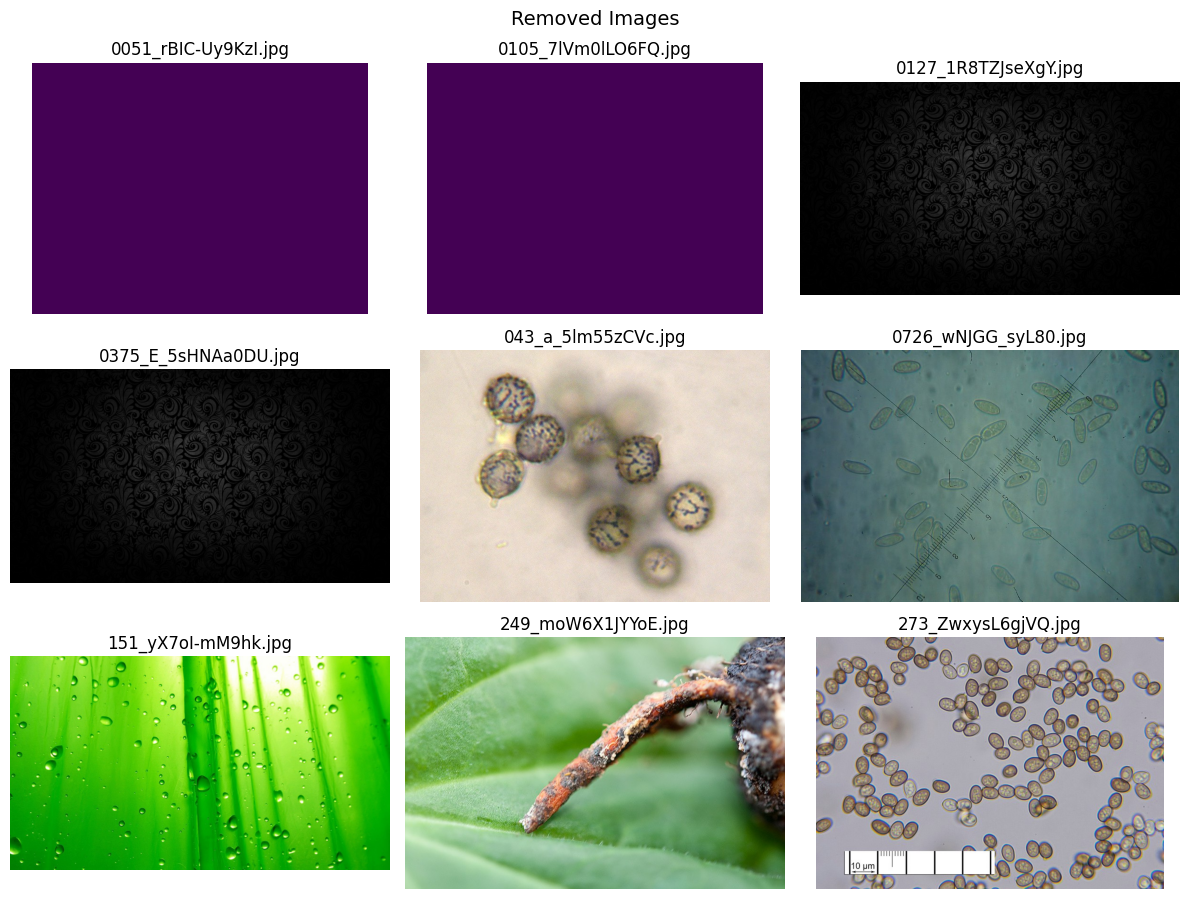

In [2]:
unwanted_images = [
    "Mushrooms/Agaricus/249_moW6X1JYYoE.jpg",
    "Mushrooms/Agaricus/273_ZwxysL6gjVQ.jpg",
    "Mushrooms/Boletus/0051_rBIC-Uy9KzI.jpg",
    "Mushrooms/Boletus/0105_7lVm0lLO6FQ.jpg",
    "Mushrooms/Boletus/0726_wNJGG_syL80.jpg",
    "Mushrooms/Lactarius/0127_1R8TZJseXgY.jpg",
    "Mushrooms/Lactarius/0375_E_5sHNAa0DU.jpg",
    "Mushrooms/Russula/043_a_5lm55zCVc.jpg",
    "Mushrooms/Russula/151_yX7oI-mM9hk.jpg",
]
os.makedirs("unwanted_images", exist_ok=True)
for img_path in unwanted_images:
    dest_path = os.path.join("unwanted_images", os.path.basename(img_path))
    if not os.path.exists(dest_path):
        shutil.move(img_path, "unwanted_images")

unwanted_images = [
    os.path.join("unwanted_images", img) for img in os.listdir("unwanted_images")
]
plt.figure(figsize=(12, 12))
plt.suptitle("Removed Images", fontsize=14, y=0.985)
for i, img_path in enumerate(unwanted_images):
    img = Image.open(img_path)
    plt.subplot(len(unwanted_images) // 3 + 1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(img_path))
plt.tight_layout()

- Most images are well-centered close-ups of mushrooms on the ground, captured with good picture quality and lighting in a portrait orientation. These are the types of images the app users would have to take.
- Some images are highly zoomed in caps or stems, making it difficult to recognize them as mushrooms without prior knowledge of what it is.
- Each label shows variation in color and shape, with species often including subspecies that differ significantly.
- One removed image might depict a growing mushroom stem or a root and could potentially have been included in the dataset.
- The dataset included some images of spores.

### Duplicates

Duplicates can lead the model to "memorize" patterns, creating a misleading impression of its performance and failing to reflect its ability to predict unseen data. 

Perceptual hashing detects identical or visually similar images, even if they have minor variations such as resizing, compression, or slight edits.

In [3]:
threshold = 2
os.makedirs("removed_duplicates", exist_ok=True)
duplicates = []
hashes = {}
for class_folder in os.listdir("Mushrooms"):
    class_path = os.path.join("Mushrooms", class_folder)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            hash_value = imagehash.average_hash(img)
            duplicate_found = False
            for existing_hash in hashes.keys():
                if hash_value - existing_hash <= threshold:
                    duplicates.append(img_path)
                    duplicate_found = True
                    break
            if not duplicate_found:
                hashes[hash_value] = img_path

for duplicate_path in duplicates:
    class_folder = os.path.basename(os.path.dirname(duplicate_path))
    target_folder = os.path.join("removed_duplicates", class_folder)
    os.makedirs(target_folder, exist_ok=True)
    shutil.move(
        duplicate_path, os.path.join(target_folder, os.path.basename(duplicate_path))
    )

duplicates_counts = {}
for class_folder in os.listdir("removed_duplicates"):
    class_path = os.path.join("removed_duplicates", class_folder)
    if os.path.isdir(class_path):
        duplicates_counts[class_folder] = len(os.listdir(class_path))
print("Number of removed duplicates:")
for class_name, count in duplicates_counts.items():
    print(f"{class_name}: {count}")

Number of removed duplicates:
Agaricus: 2
Amanita: 5
Boletus: 1
Cortinarius: 2
Hygrocybe: 1
Lactarius: 68
Russula: 8


- Multiple images were detected, and upon inspection, they were almost exact duplicates of other images.
- Adjusting the duplicate detection threshold from 0 to 2 identified approximately 10 additional images as duplicates. Further refinement could involve exploring different threshold values and reviewing the identified images.
- Further manual review of the dataset revealed there are still some duplicate images with slight variations in aspect ratios (e.g., "Agaricus/158_eoGibawlD-A.jpg" and "Agaricus/159_nMO_hMm6V4A.jpg"). I could further refine duplicate removal.

### Corrupted Images

After attempting to train the model, I discovered that some images may be causing errors.

In [4]:
corrupted_files = []
corrupted_folder = "corrupted_images"
os.makedirs(corrupted_folder, exist_ok=True)

for root, _, files in os.walk("Mushrooms"):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except Exception as e:
            print(f"Corrupted file found: {file_path}")
            corrupted_files.append(file_path)

for file_path in corrupted_files:
    destination_path = os.path.join(corrupted_folder, os.path.basename(file_path))
    shutil.move(file_path, destination_path)

corrupted_images = os.listdir(corrupted_folder)
print("Corrupted images moved to 'corrupted_images' folder:")
for image in corrupted_images:
    print(image)

Corrupted images moved to 'corrupted_images' folder:
092_43B354vYxm8.jpg


- One image file had missing or incomplete data, and removing it resolved issues, allowing the model to work.

### Color Channels

In [5]:
non_rgb_images = []
for class_folder in os.listdir("Mushrooms"):
    class_path = os.path.join("Mushrooms", class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                if img.mode != "RGB":
                    non_rgb_images.append(img_path)

if non_rgb_images:
    print("Non-RGB images found:")
    print("\n".join(non_rgb_images))
else:
    print("All images are RGB.")

All images are RGB.


## Class Balance

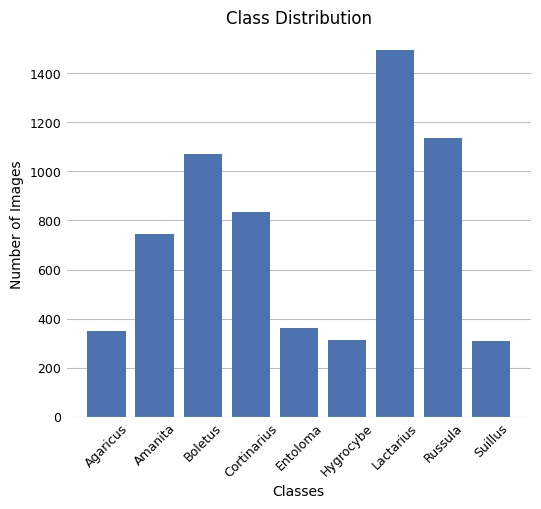

Total number of images: 6617


In [65]:
class_counts = {}
for class_name in os.listdir("Mushrooms"):
    class_path = os.path.join("Mushrooms", class_name)
    class_counts[class_name] = len(os.listdir(class_path))
plt.bar(class_counts.keys(), class_counts.values(), zorder=2)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()
total_images = sum(class_counts.values())
print(f"Total number of images: {total_images}")

- It's important to adjust the loss function with weights that match the class proportions.

## Image Dimensions

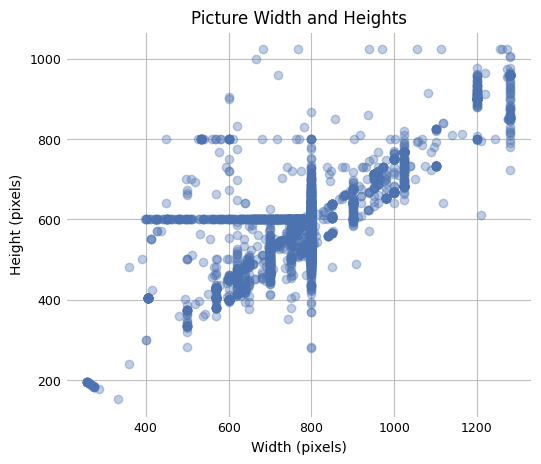

In [7]:
widths, heights = [], []
for class_folder in os.listdir("Mushrooms"):
    class_path = os.path.join("Mushrooms", class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)

plt.scatter(widths, heights, alpha=0.35, zorder=2)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Picture Width and Heights")
plt.grid(True)

- The images vary in size and will be preprocessed to match the requirements specified in the model (ResNet) documentation.

## Summary

Most of the images are taken in clear daylight with good camera conditions, and the mushrooms are well-centered. If app users don't take similar quality photos, the model's performance would suffer. The dataset is relatively clean but required some adjustments:

- 9 images were removed during preprocessing as they did not depict mushrooms.
- Close to 90 duplicate images were identified and removed, though further refinement could address duplicates with different aspect ratios.
- A single corrupted image was excluded.
- The dataset includes 9 classes, which will require balancing.

# Deep Learning

The main objectives for this part of the notebook are:

- Develop a well-performing model for mushroom classification.
- Analyze model errors to identify potential areas for improvement.
- Address the issue of poisonous mushrooms being misclassified as edible.

To evaluate the model's performance, accuracy will be the primary metric. Additionally, the confusion matrix or classification report will be analyzed to confirm that all classes are classified equally well.

The training will utilize my computer's GPU to speed up computations.

In [8]:
print(f"CUDA available for GPU acceleration: {torch.cuda.is_available()}")
print(f"Number of NVIDIA GPUs detected: {torch.cuda.device_count()}")

CUDA available for GPU acceleration: True
Number of NVIDIA GPUs detected: 1


## Data Preprocessing

The chosen augmentations aim to increase data variability while staying consistent with the characteristics observed in the available images during EDA.

- Horizontal flipping is used to expand the dataset, as many mushrooms are symmetrical.
- Small rotations of ±10 degrees account for variations in orientation without introducing unrealistic distortions, as most images are centered. This augmentation did not significantly affect model performance when applied, while rotations of ±20 degrees slightly reduced performance.

I also considered, but did not apply:

- I tested random cropping, which reduced the overall model accuracy by approximately 0.04%. This is likely because most images in the dataset are already well-centered.
- Color jitter is unnecessary as the images were captured under consistent lighting.
- No Blur is used since the dataset contains clear images.

Resizing, cropping and normalization are applied as specified in the ResNet documentation. Further discussion on augmentations is in the sections on model evaluation and conclusions. 

In [9]:
preprocess = Compose(
    [
        RandomHorizontalFlip(),
        RandomRotation(10),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageFolder(root="Mushrooms", transform=preprocess)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
num_workers = os.cpu_count() - 2
train_loader = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)
test_loader = DataLoader(
    test_set,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

class_labels = dataset.classes
train_labels = [dataset.samples[i][1] for i in train_set.indices]
train_class_counts = Counter(train_labels)
num_classes = len(dataset.classes)
train_class_weights = [1.0 / train_class_counts[i] for i in range(num_classes)]
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float)

## ResNet18

I will start with simpler model and progressively increase complexity to improve performance:

1) Using a pretrained model with only the output layer replaced and trained.
2) Adding and training a new intermediate layer between the backbone and output layer.
3) Unfreezing approximately half of the model's parameters for fine-tuning.
4) Fully unfreezing all layers for full fine-tuning.

About the model:

- Softmax Cross Entropy Loss is used for multi-class classification where only one class is correct, such as predicting a single mushroom species out of availible multiple options.
- AdamW was chosen as the optimizer because it combines Adam with weight decay for regularization. It is a recommended option for smaller datasets, such as this one, containing approximately 6.6 thousand images. I also trained the model using Adam, but the performance differences were minimal.
- A batch size of 16 was used due to limitations in my computer's resources, even though larger batch sizes are generally recommended to reduce sudden changes to weights by averaging over more samples.
- Learning rate and number of epochs were adjusted multiple times based on validation loss trends. If the loss line oscillates, decreases too quickly, or continues to decrease at the end of the training, it is a strong indication that the model would benefit from retraining with a lower learning rate or additional epochs to improve performance.

This sub-section focuses on training ResNet18, while ResNet34 will be covered in the following sub-section. Results will be summarized after the training of ResNet34.

### Transfer Learning with New Output Layer

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=14` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8078169822692871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


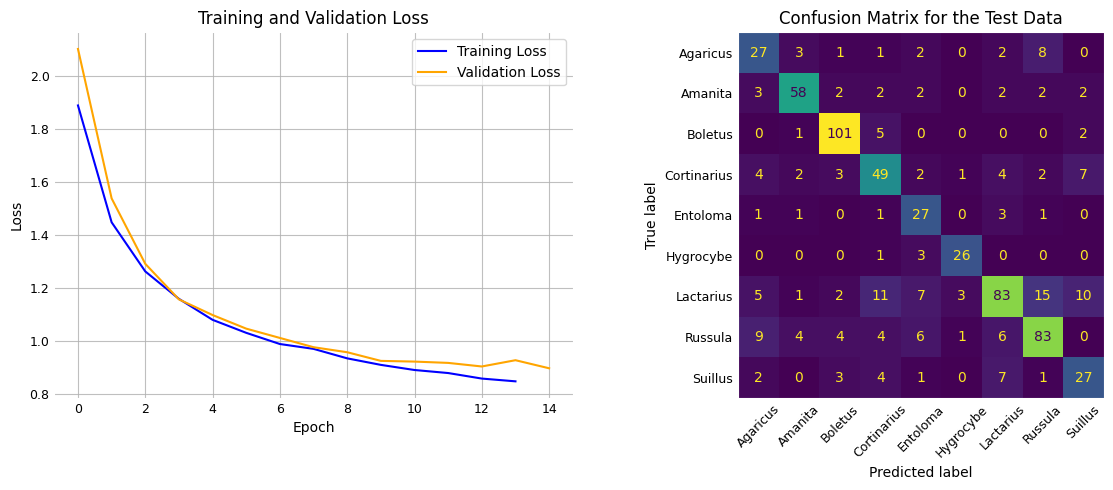

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.53      0.61      0.57        44
     Amanita       0.83      0.79      0.81        73
     Boletus       0.87      0.93      0.90       109
 Cortinarius       0.63      0.66      0.64        74
    Entoloma       0.54      0.79      0.64        34
   Hygrocybe       0.84      0.87      0.85        30
   Lactarius       0.78      0.61      0.68       137
     Russula       0.74      0.71      0.72       117
     Suillus       0.56      0.60      0.58        45

    accuracy                           0.73       663
   macro avg       0.70      0.73      0.71       663
weighted avg       0.73      0.73      0.73       663



In [10]:
class ResNet18TransferLearning(pl.LightningModule):
    """A PyTorch Lightning model for transfer learning using a pretrained ResNet-18 backbone."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the ResNet-18 model for transfer learning, freezing the backbone and modifying the final layer."""
        super().__init__()

        # Load the pretrained ResNet model
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model."""
        return self.model(x)

    def training_step(self, batch: tuple) -> torch.Tensor:
        """Defines the training step where loss is computed."""
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False)
        self.epoch_training_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self) -> None:
        """Called at the end of each training epoch to compute and log the average training loss."""
        avg_train_loss = sum(self.epoch_training_losses) / len(
            self.epoch_training_losses
        )
        self.training_losses.append(avg_train_loss)
        self.log("avg_train_loss", avg_train_loss, prog_bar=True)
        self.epoch_training_losses = []

    def validation_step(self, batch: tuple) -> torch.Tensor:
        """Defines the validation step where loss is computed."""
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        """Called at the end of each validation epoch to compute and store the average validation loss."""
        avg_val_loss = torch.tensor(
            self.trainer.callback_metrics["val_loss"].item()
        ).mean()
        self.validation_losses.append(avg_val_loss.item())

    def test_step(self, batch: tuple) -> None:
        """Defines the test step where predictions and loss are computed."""
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss, prog_bar=True)

        preds = torch.argmax(outputs, dim=1)
        self.test_preds.extend(preds.cpu().numpy())
        self.test_targets.extend(labels.cpu().numpy())

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configures and returns the optimizer."""
        return AdamW(self.parameters(), lr=self.learning_rate)


resnet18_transfer_learning = ResNet18TransferLearning(num_classes, 3e-4)
trainer = pl.Trainer(
    max_epochs=14,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet18_transfer_learning, train_loader, val_loader)
_ = trainer.test(resnet18_transfer_learning, test_loader)
cnn_evaluation(resnet18_transfer_learning, class_labels)
torch.save(
    resnet18_transfer_learning.state_dict(), "resnet18_transfer_learning_new_output.pth"
)

### Additional New Intermediate Layer

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
267 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.775    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.818493664264679
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


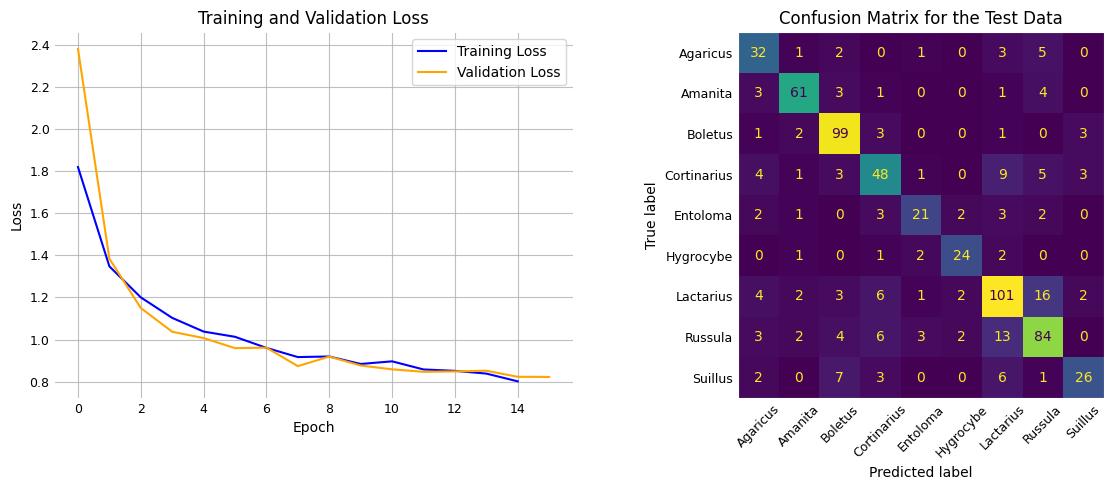

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.63      0.73      0.67        44
     Amanita       0.86      0.84      0.85        73
     Boletus       0.82      0.91      0.86       109
 Cortinarius       0.68      0.65      0.66        74
    Entoloma       0.72      0.62      0.67        34
   Hygrocybe       0.80      0.80      0.80        30
   Lactarius       0.73      0.74      0.73       137
     Russula       0.72      0.72      0.72       117
     Suillus       0.76      0.58      0.66        45

    accuracy                           0.75       663
   macro avg       0.75      0.73      0.74       663
weighted avg       0.75      0.75      0.75       663



In [11]:
class ResNet18AdditionalLayer(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-18 backbone with an additional custom layer."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with a custom intermediate layer on top of ResNet-18 backbone."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet18_additional_layer = ResNet18AdditionalLayer(num_classes, 2e-4)
state_dict = torch.load("resnet18_transfer_learning_new_output.pth", weights_only=True)
resnet18_additional_layer.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet18_additional_layer, train_loader, val_loader)
_ = trainer.test(resnet18_additional_layer, test_loader)
cnn_evaluation(resnet18_additional_layer, class_labels)
torch.save(resnet18_additional_layer.state_dict(), "resnet18_additional_layer.pth")

- Adding this layer likely results in an accuracy improvement of approximately 1% or less.

### 10 Head Layers Unfrozen

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.0 M     Trainable params
6.5 M     Non-trainable params
11.4 M    Total params
45.775    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=9` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5177642107009888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


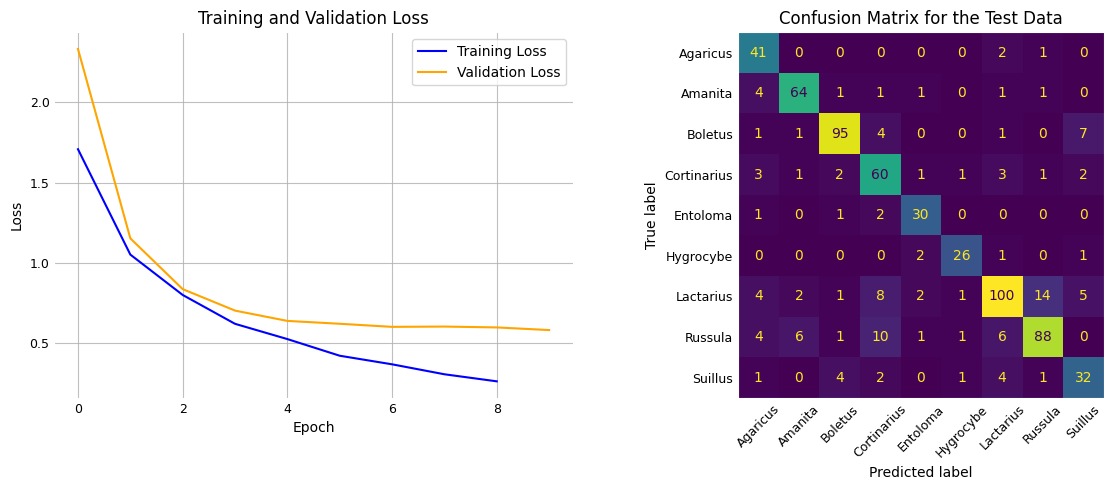

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.69      0.93      0.80        44
     Amanita       0.86      0.88      0.87        73
     Boletus       0.90      0.87      0.89       109
 Cortinarius       0.69      0.81      0.75        74
    Entoloma       0.81      0.88      0.85        34
   Hygrocybe       0.87      0.87      0.87        30
   Lactarius       0.85      0.73      0.78       137
     Russula       0.83      0.75      0.79       117
     Suillus       0.68      0.71      0.70        45

    accuracy                           0.81       663
   macro avg       0.80      0.83      0.81       663
weighted avg       0.82      0.81      0.81       663



In [13]:
class ResNet18Unfrozen10(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-18 backbone, unfrozen for the last 10 layers."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with the last 10 layers unfrozen and a custom intermediate layer."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone by default
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Unfreeze the last 10 layers (closer to the output)
        params = list(self.model.parameters())
        for param in params[-10:]:
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet18_unfrozen_10 = ResNet18Unfrozen10(num_classes, 5e-5)
state_dict = torch.load("resnet18_additional_layer.pth", weights_only=True)
resnet18_unfrozen_10.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=9,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet18_unfrozen_10, train_loader, val_loader)
_ = trainer.test(resnet18_unfrozen_10, test_loader)
cnn_evaluation(resnet18_unfrozen_10, class_labels)
torch.save(resnet18_unfrozen_10.state_dict(), "resnet18_unfrozen_10.pth")

### All Layers Unfrozen

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.4 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.775    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40451961755752563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


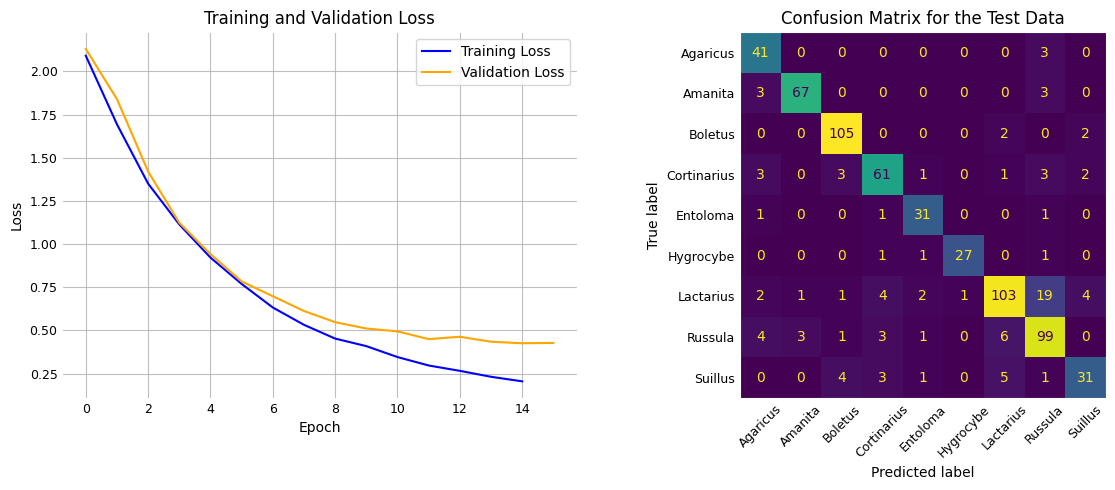

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.76      0.93      0.84        44
     Amanita       0.94      0.92      0.93        73
     Boletus       0.92      0.96      0.94       109
 Cortinarius       0.84      0.82      0.83        74
    Entoloma       0.84      0.91      0.87        34
   Hygrocybe       0.96      0.90      0.93        30
   Lactarius       0.88      0.75      0.81       137
     Russula       0.76      0.85      0.80       117
     Suillus       0.79      0.69      0.74        45

    accuracy                           0.85       663
   macro avg       0.86      0.86      0.85       663
weighted avg       0.86      0.85      0.85       663



In [14]:
class ResNet18UnfrozenAll(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-18 backbone with all layers unfrozen."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with all layers unfrozen and a custom intermediate layer."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Unfreeze all layers in the backbone by default
        for param in self.model.parameters():
            param.requires_grad = True

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet18_unfrozen_all = ResNet18UnfrozenAll(num_classes, 1e-5)
state_dict = torch.load("resnet18_unfrozen_10.pth", weights_only=True)
resnet18_unfrozen_all.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet18_unfrozen_all, train_loader, val_loader)
_ = trainer.test(resnet18_unfrozen_all, test_loader)
cnn_evaluation(resnet18_unfrozen_all, class_labels)

## ResNet34

### Transfer Learning with New Output Layer

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 21.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
4.6 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.157    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=24` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8635402917861938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


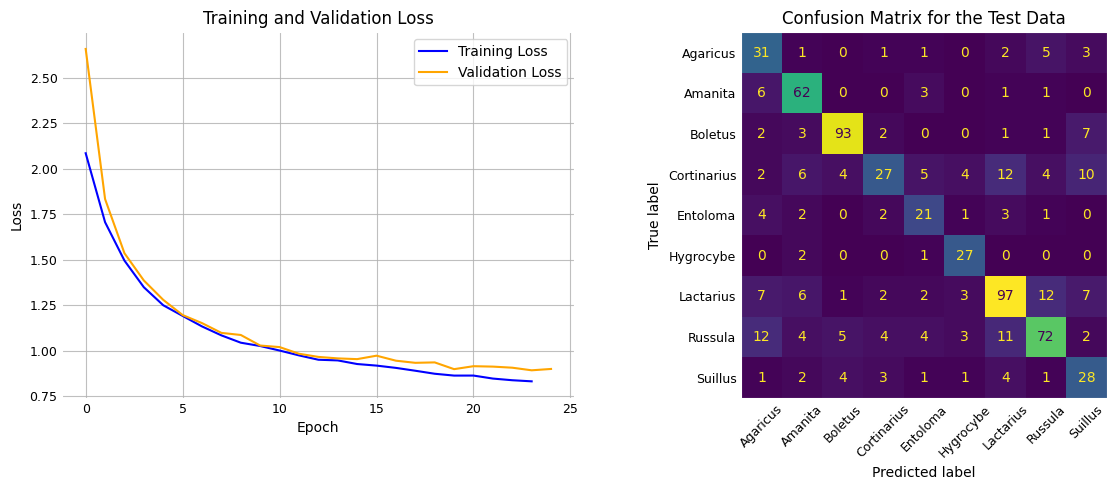

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.48      0.70      0.57        44
     Amanita       0.70      0.85      0.77        73
     Boletus       0.87      0.85      0.86       109
 Cortinarius       0.66      0.36      0.47        74
    Entoloma       0.55      0.62      0.58        34
   Hygrocybe       0.69      0.90      0.78        30
   Lactarius       0.74      0.71      0.72       137
     Russula       0.74      0.62      0.67       117
     Suillus       0.49      0.62      0.55        45

    accuracy                           0.69       663
   macro avg       0.66      0.69      0.66       663
weighted avg       0.70      0.69      0.69       663



In [15]:
class ResNet34TransferLearning(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-34 backbone for transfer learning."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the ResNet-34 model for transfer learning, freezing the backbone and modifying the final layer."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet34_transfer_learning = ResNet34TransferLearning(num_classes, 1.5e-4)
trainer = pl.Trainer(
    max_epochs=24,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet34_transfer_learning, train_loader, val_loader)
_ = trainer.test(resnet34_transfer_learning, test_loader)
cnn_evaluation(resnet34_transfer_learning, class_labels)
torch.save(
    resnet34_transfer_learning.state_dict(), "resnet34_transfer_learning_new_output.pth"
)

### Additional New Intermediate Layer

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
267 K     Trainable params
21.3 M    Non-trainable params
21.6 M    Total params
86.208    Total estimated model params size (MB)
121       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=17` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8315847516059875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


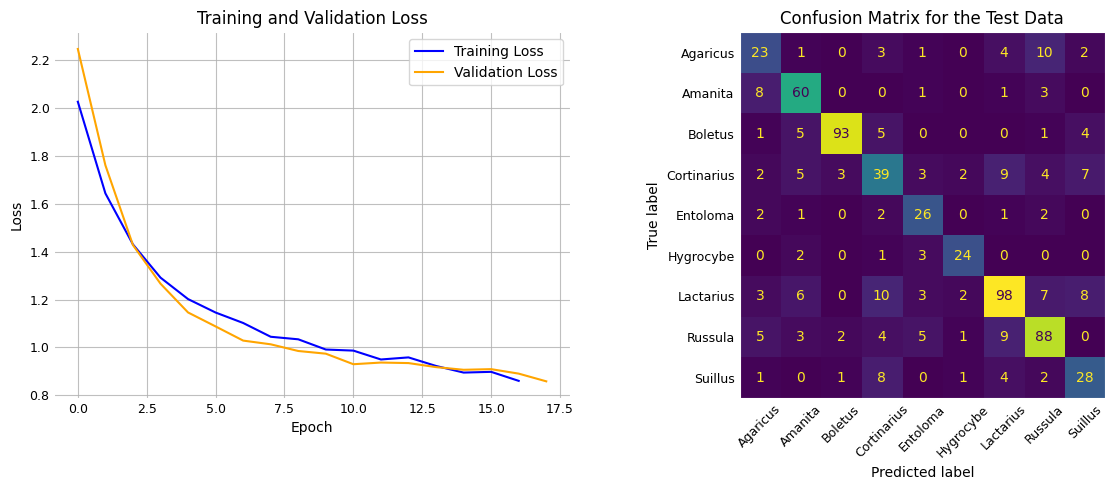

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.51      0.52      0.52        44
     Amanita       0.72      0.82      0.77        73
     Boletus       0.94      0.85      0.89       109
 Cortinarius       0.54      0.53      0.53        74
    Entoloma       0.62      0.76      0.68        34
   Hygrocybe       0.80      0.80      0.80        30
   Lactarius       0.78      0.72      0.75       137
     Russula       0.75      0.75      0.75       117
     Suillus       0.57      0.62      0.60        45

    accuracy                           0.72       663
   macro avg       0.69      0.71      0.70       663
weighted avg       0.73      0.72      0.72       663



In [16]:
class ResNet34AdditionalLayer(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-34 backbone with an additional custom layer."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with a custom intermediate layer and a frozen ResNet-34 backbone."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet34_additional_layer = ResNet34AdditionalLayer(num_classes, 7e-5)
state_dict = torch.load("resnet34_transfer_learning_new_output.pth", weights_only=True)
resnet34_additional_layer.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=17,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet34_additional_layer, train_loader, val_loader)
_ = trainer.test(resnet34_additional_layer, test_loader)
cnn_evaluation(resnet34_additional_layer, class_labels)
torch.save(resnet34_additional_layer.state_dict(), "resnet34_additional_layer.pth")

### 20 Head Layers Unfrozen

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
9.8 M     Trainable params
11.7 M    Non-trainable params
21.6 M    Total params
86.208    Total estimated model params size (MB)
121       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=13` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4821707308292389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


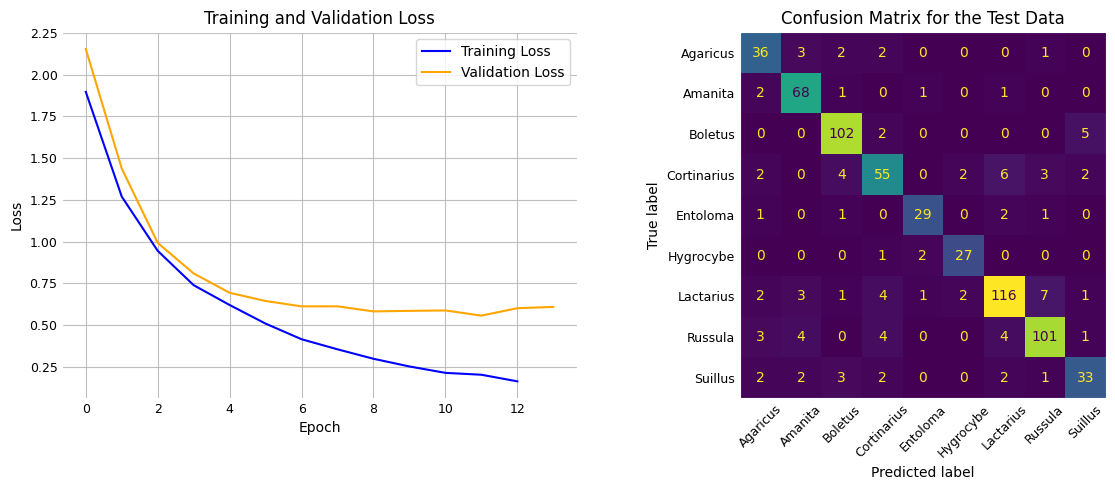

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.75      0.82      0.78        44
     Amanita       0.85      0.93      0.89        73
     Boletus       0.89      0.94      0.91       109
 Cortinarius       0.79      0.74      0.76        74
    Entoloma       0.88      0.85      0.87        34
   Hygrocybe       0.87      0.90      0.89        30
   Lactarius       0.89      0.85      0.87       137
     Russula       0.89      0.86      0.87       117
     Suillus       0.79      0.73      0.76        45

    accuracy                           0.86       663
   macro avg       0.84      0.85      0.84       663
weighted avg       0.86      0.86      0.85       663



In [18]:
class ResNet34Unfrozen20(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-34 backbone with the last 20 layers unfrozen."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with the last 20 layers unfrozen and a custom intermediate layer."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        # Freeze all layers in the backbone by default
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Unfreeze the last 20 layers
        params = list(self.model.parameters())
        for param in params[-20:]:
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []


resnet34_unfrozen_20 = ResNet34Unfrozen20(num_classes, 2e-5)
state_dict = torch.load("resnet34_additional_layer.pth", weights_only=True)
resnet34_unfrozen_20.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=13,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet34_unfrozen_20, train_loader, val_loader)
_ = trainer.test(resnet34_unfrozen_20, test_loader)
cnn_evaluation(resnet34_unfrozen_20, class_labels)
torch.save(resnet34_unfrozen_20.state_dict(), "resnet34_unfrozen_20.pth")

### All Layers Unfrozen

I will add code to visualize the misclassified images.

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 21.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.208    Total estimated model params size (MB)
121       Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=11` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3577083945274353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


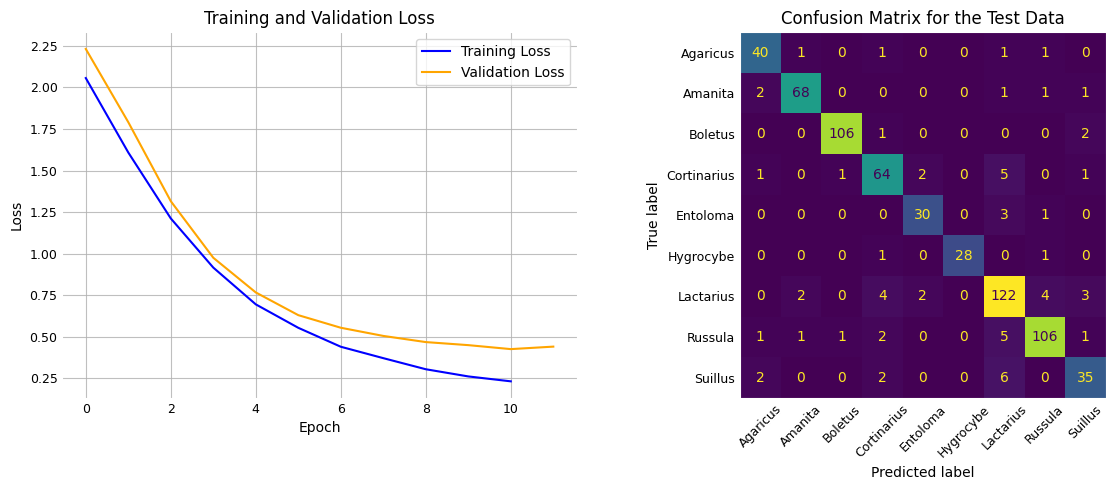

Classification Report:
              precision    recall  f1-score   support

    Agaricus       0.87      0.91      0.89        44
     Amanita       0.94      0.93      0.94        73
     Boletus       0.98      0.97      0.98       109
 Cortinarius       0.85      0.86      0.86        74
    Entoloma       0.88      0.88      0.88        34
   Hygrocybe       1.00      0.93      0.97        30
   Lactarius       0.85      0.89      0.87       137
     Russula       0.93      0.91      0.92       117
     Suillus       0.81      0.78      0.80        45

    accuracy                           0.90       663
   macro avg       0.90      0.90      0.90       663
weighted avg       0.90      0.90      0.90       663



In [25]:
class ResNet34UnfrozenAll(ResNet18TransferLearning):
    """A PyTorch Lightning model using a pretrained ResNet-34 backbone with all layers unfrozen."""

    def __init__(self, num_classes: int, learning_rate: float) -> None:
        """Initializes the model with all layers unfrozen and a custom intermediate layer."""
        super().__init__(num_classes, learning_rate)

        # Load the pretrained ResNet model
        self.model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

        # Unfreeze all layers in the backbone by default
        for param in self.model.parameters():
            param.requires_grad = True

        # Add a custom intermediate layer and retain the output layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss(weight=train_class_weights)
        self.learning_rate = learning_rate
        self.training_losses = []
        self.validation_losses = []
        self.epoch_training_losses = []
        self.test_preds = []
        self.test_targets = []
        self.misclassified_images = []
        self.misclassified_labels = []
        self.misclassified_preds = []

    def test_step(self, batch: tuple) -> None:
        """Defines the test step where predictions, loss, and misclassified images are computed."""
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss, prog_bar=True)
        preds = torch.argmax(outputs, dim=1)
        self.test_preds.extend(preds.cpu().numpy())
        self.test_targets.extend(labels.cpu().numpy())
        misclassified = preds != labels
        if misclassified.any():
            misclassified_images = images[misclassified]
            misclassified_labels = labels[misclassified]
            misclassified_preds = preds[misclassified]
            self.misclassified_images.extend(misclassified_images.cpu())
            self.misclassified_labels.extend(misclassified_labels.cpu())
            self.misclassified_preds.extend(misclassified_preds.cpu())

    def show_misclassified_images(self, n: int = 5) -> None:
        """Displays a grid of misclassified images with true and predicted labels."""
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        num_rows = (n + 4) // 5
        fig, axes = plt.subplots(num_rows, 5, figsize=(14, num_rows * 4))
        axes = axes.flatten()
        for i in range(n):
            ax = axes[i]
            img = self.misclassified_images[i].cpu()
            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
            img = img.permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.set_title(
                f"True: {self.misclassified_labels[i]}, Pred: {self.misclassified_preds[i]}",
                pad=13,
            )
            ax.axis("off")
        plt.tight_layout(h_pad=0)
        plt.show()


resnet34_unfrozen_all = ResNet34UnfrozenAll(num_classes, 8e-6)
state_dict = torch.load("resnet34_unfrozen_20.pth", weights_only=True)
resnet34_unfrozen_all.model.load_state_dict(state_dict, strict=False)
trainer = pl.Trainer(
    max_epochs=11,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    enable_progress_bar=False,
)
trainer.fit(resnet34_unfrozen_all, train_loader, val_loader)
_ = trainer.test(resnet34_unfrozen_all, test_loader)
cnn_evaluation(resnet34_unfrozen_all, class_labels)
torch.save(resnet34_unfrozen_all.state_dict(), "resnet34_finished.pth")

## Summary

- The final model achieves 90% accuracy on the test dataset, successfully classifying most mushroom images with similar performance across all classes.
- Suillus is classified slightly worse than other classes. To address this, I could increase its weight in the loss function, adjust the prediction threshold, or apply targeted augmentations. Since the sample size for this mushroom type is small, obtaining additional data would also be very beneficial.
- The performance difference between the two ResNet models showed an improvement of around 1-3% for ResNet34.
- Adding an intermediate layer had an unclear impact, as further tuning the model with progressively smaller learning rates might have achieved similar improvements. Most of the performance gains came from unfreezing layers.
- Using a smaller or larger learning rate could potentially lead to slight improvements in the final model's performance.

## Model Performance Evaluation 

### Missclassified Images

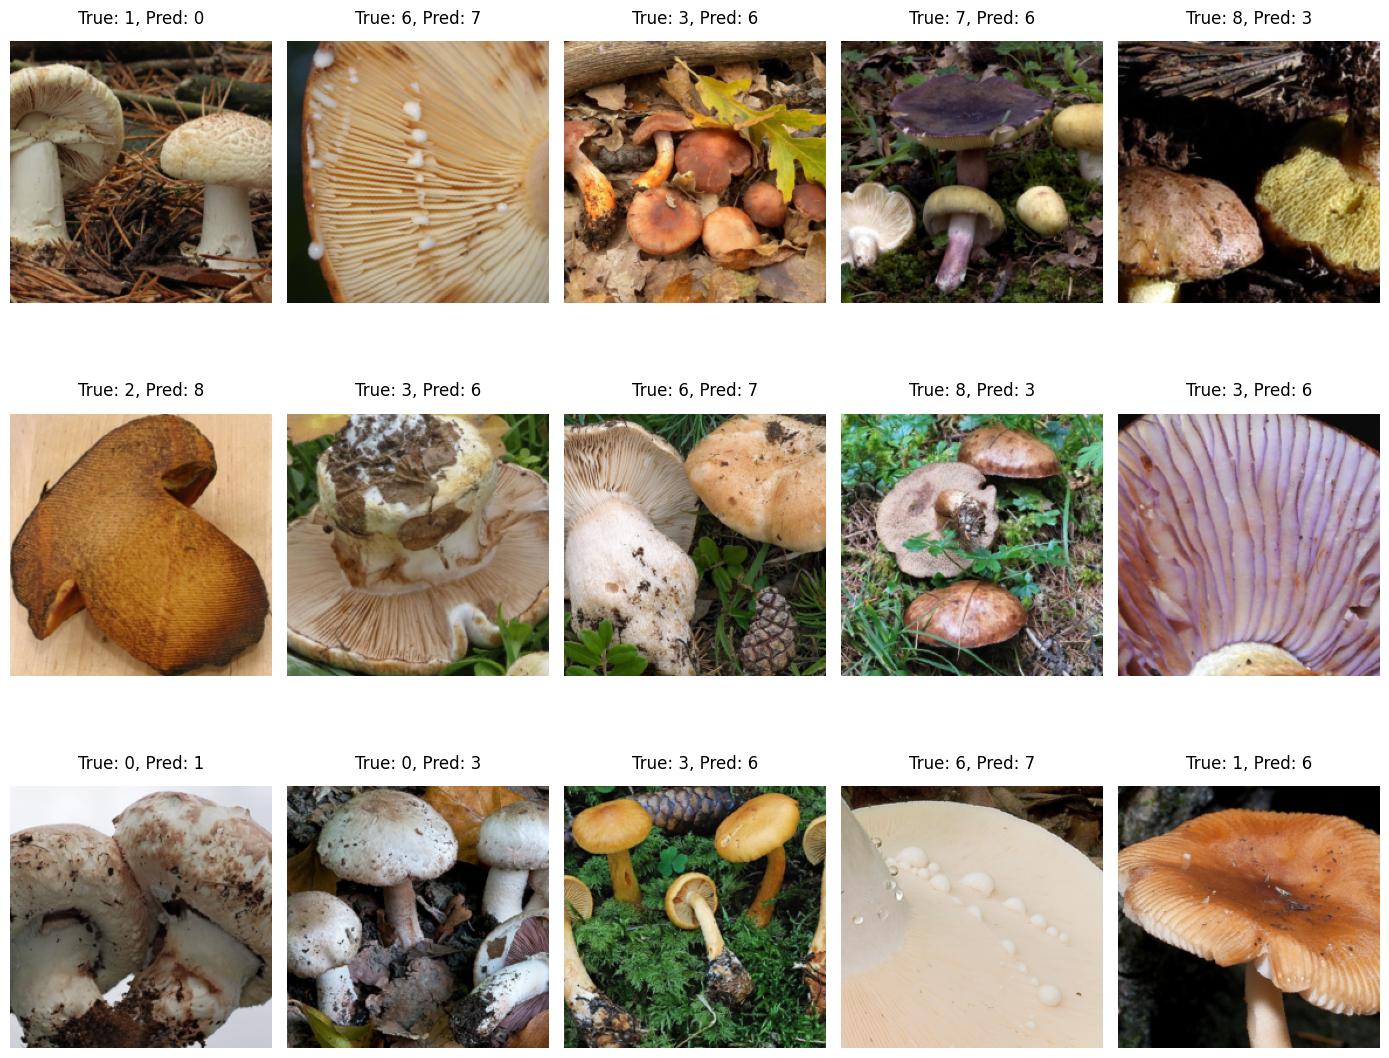

In [26]:
resnet34_unfrozen_all.show_misclassified_images(15)

- Some misclassified images are challenging to classify due to being highly zoomed in or taken from unusual angles. To address this, I could further explore rotational or random cropping augmentations, even though prior tests showed they did not help performance. Zoom, perspective and cutout augmentations could be explored.
- Misclassifications may also stem from significant variations within a species, where some subspecies appear more similar to those of other species. For example, certain subspecies of Russula (7) resemble poisonous subspecies of Cortinarius (3). Predicting subspecies labels could help the model better capture these relationships.

### Explaining Predictions with LIME

LIME highlights the areas of an image that were most important for the model's prediction. Cyan areas support the predicted class, while red areas oppose it. This helps visualize which parts of the image influenced the model's decision.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

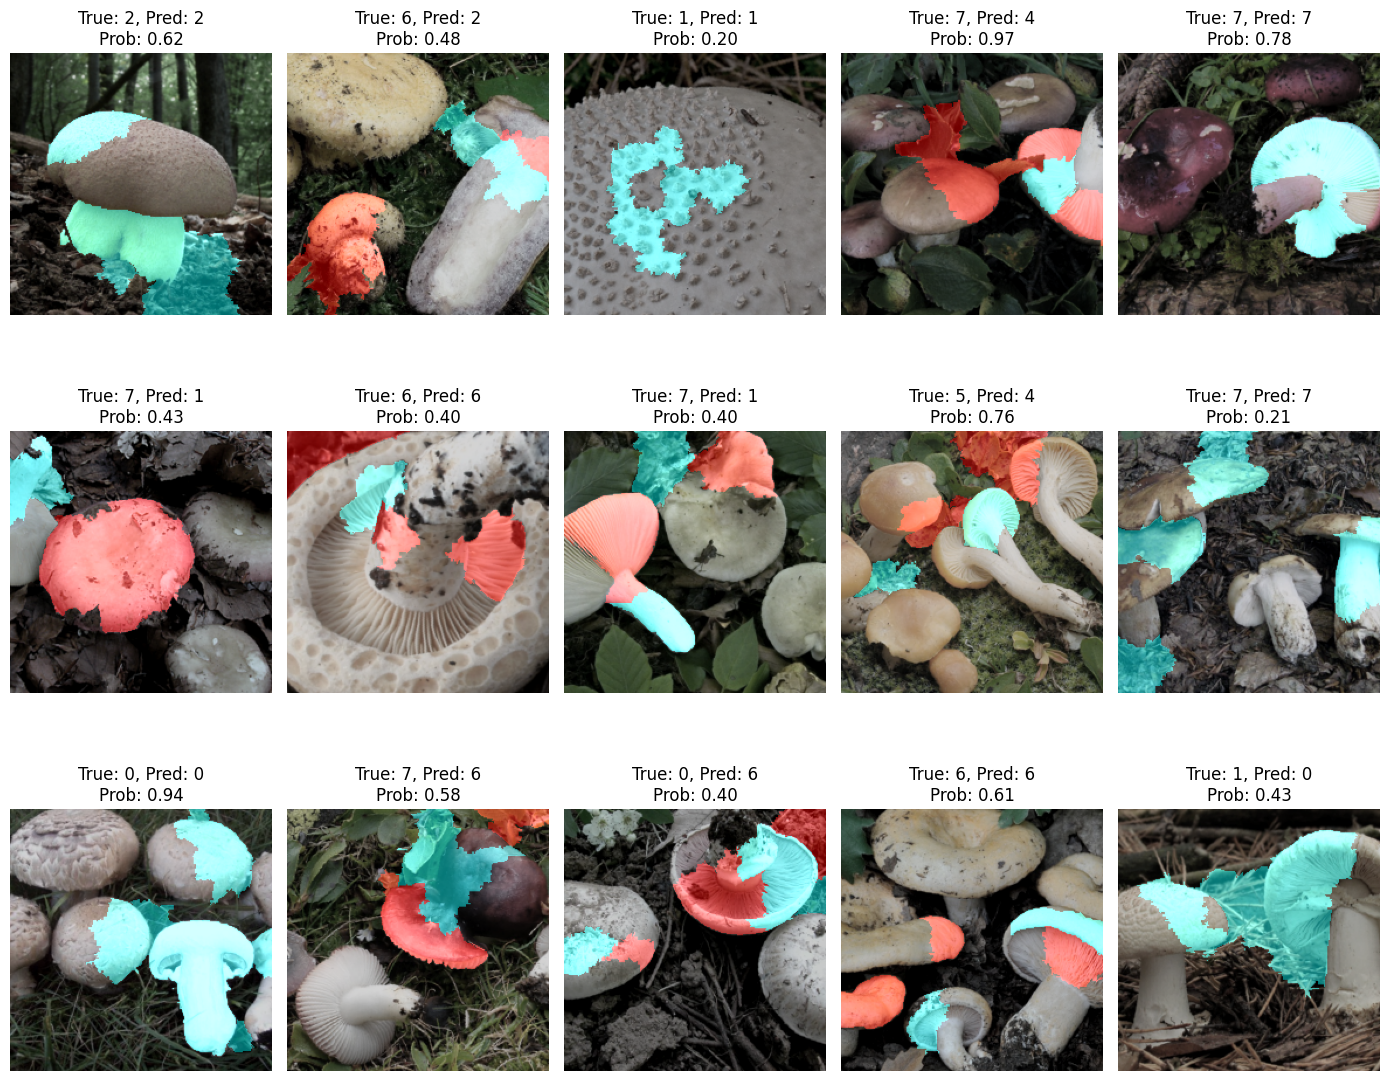

In [27]:
lime_plots(resnet34_unfrozen_all, test_loader, 15)

- The model sometimes relys on background information, such as grass or leaves, for both correctly and incorrectly classified images, rather than focusing on the mushroom itself. This suggests the need for additional preprocessing steps, such as cropping to isolate the mushroom, blurring the background or masking irrelevant areas.
- When I accidentally flipped the images, I noticed that the model sometimes relied on different areas of the images for predictions, which is not ideal. Additional preprocessing could help address this.

### Inference Speed

In [28]:
resnet34_unfrozen_all.eval()
for images, labels in test_loader:
    img_tensor = images[1].unsqueeze(0)
    device = torch.device("cuda")
    resnet34_unfrozen_all.to(device)
    img_tensor = img_tensor.to(device)
    start_time = time.time()
    with torch.no_grad():
        output = resnet34_unfrozen_all(img_tensor)
    end_time = time.time()
    inference_time = end_time - start_time
    break
print(f"Inference Time: {inference_time:.4f} seconds")

Inference Time: 0.0141 seconds


- When the model and the input tensor are on the same device (GPU), time to classify an image is 0.01 seconds.

## Handling Poisonous Mushroom Misclassification

This section addresses the issue of poisonous mushrooms being misclassified as edible (false negatives). While this consideration emerged after evaluating the model’s results, it would have been better to account for it earlier in the project. To tackle this, I will adjust prediction thresholds for the poisonous species: "Amanita," "Cortinarius," and "Entoloma." Although other poisonous subspecies exist, there is no avilible labels for this and I will simplify the task to focus on these three.

### Adjusting Prediction Thresholds

In [29]:
resnet34_unfrozen_all.eval()
logits_list = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(next(resnet34_unfrozen_all.parameters()).device)
        labels = labels.to(next(resnet34_unfrozen_all.parameters()).device)
        outputs = resnet34_unfrozen_all(images)
        logits_list.append(outputs)
        true_labels.append(labels)
logits = torch.cat(logits_list, dim=0)
true_labels = torch.cat(true_labels, dim=0)
probabilities = torch.softmax(logits, dim=1)
poisonous_classes = ["Amanita", "Cortinarius", "Entoloma"]
poisonous_class_indices = [class_labels.index(cls) for cls in poisonous_classes]

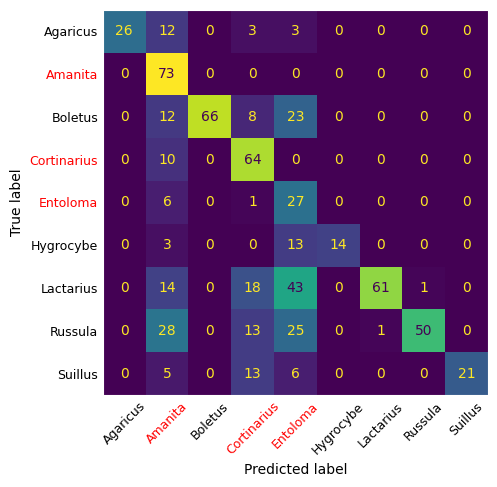

              precision    recall  f1-score   support

    Agaricus       1.00      0.59      0.74        44
     Amanita       0.45      1.00      0.62        73
     Boletus       1.00      0.61      0.75       109
 Cortinarius       0.53      0.86      0.66        74
    Entoloma       0.19      0.79      0.31        34
   Hygrocybe       1.00      0.47      0.64        30
   Lactarius       0.98      0.45      0.61       137
     Russula       0.98      0.43      0.60       117
     Suillus       1.00      0.47      0.64        45

    accuracy                           0.61       663
   macro avg       0.79      0.63      0.62       663
weighted avg       0.84      0.61      0.63       663



In [ ]:
individual_thresholds = [0.02, 0.03, 0.0025]

species_predictions = torch.zeros_like(
    probabilities, dtype=torch.int, device=probabilities.device
)
for i, threshold in zip(poisonous_class_indices, individual_thresholds):
    species_predictions[:, i] = (probabilities[:, i] > threshold).int()
final_preds = torch.argmax(species_predictions, dim=1)
fallback_preds = torch.argmax(probabilities, dim=1)
final_preds[species_predictions.sum(dim=1) == 0] = fallback_preds[
    species_predictions.sum(dim=1) == 0
]
cm = confusion_matrix(true_labels.cpu().numpy(), final_preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
ax = disp.plot(xticks_rotation=45, cmap="viridis").ax_
ax.images[-1].colorbar.remove()
ax.legend_ = None
plt.grid(False)
highlighted_classes = ["Amanita", "Cortinarius", "Entoloma"]
for label in highlighted_classes:
    if label in class_labels:
        idx = class_labels.index(label)
        ax.get_xticklabels()[idx].set_color("red")
        ax.get_yticklabels()[idx].set_color("red")
plt.show()
print(
    classification_report(
        true_labels.cpu().numpy(), final_preds.cpu().numpy(), target_names=class_labels
    )
)

- False negatives for poisonous mushrooms have been completely eliminated. By adjusting prediction probability thresholds, I aimed to preserve as much overall accuracy as possible. 
- Current metrics treat misclassifications between poisonous mushrooms as equally problematic, which is not critical for the app's purpose. Misclassifying one poisonous mushroom as another is acceptable, as it still prevents it from being eaten. Additionally, non-poisonous classes are classified individually, even though the primary concern is simply separating them from the poisonous classes.

# Conclusions

#### Main Area for Improvement:

- The main improvement for this project is to reconsider the classification strategy, which can not lead to any posnonous mushrooms being labeled as edible. Instead of predicting one of nine species, it would be more practical to classify mushrooms as either "poisonous" or "non-poisonous" first. This would align better with the app's primary goal of helping users determine edibility rather than identifying exact species. A binary classification system would simplify the models logic and maybe it would be possible to get a better separation of the two classes and better model performance. This could be done by changing the output layer of the model I have fine-tuned, fine-tuning it again and adjusting prediction threshold to get a recall of 100% for the poisonous mushrooms. 

- Overall, I could aim for a hierarchical classification where the first step would involve a CNN to classify mushrooms as "poisonous" or "non-poisonous," followed by another CNN model to predict the exact species. Alternatively, a single CNN with two output heads (Multi-Task Model) could be used — one  for binary classification and another for exact species. The best way to determine which approach gives better results is to experiment and compare their performance. This would be my next step for the project, if I was to work on it further. 

#### Additional Important Improvements:

1) As we have seen, the model struggles with edge cases where the full mushroom is not visible and occasionally relies on background information like leaves or grass for predictions. To address this, I would revisit augmentations. Since random cropping and higher rotations previously performed poorly, alternative strategies could include object detection for cropping, zoom augmentation, segmentation models to mask the background or experimenting with color-based augmentations.

2) Implement the ability to start fine-tuning with a higher learning rate and reduce it when the validation loss stops decreasing. Starting with a low learning rate means the model takes smaller steps, which can sometimes cause it to get stuck in a local minimum, and I have observed this happen in this project. Additionally, this approach would reduce fine-tuning time.

3) The project still contains some duplicate images with different aspect ratios, which could be identified and removed. Additionally, I could experiment further with the duplicate identification method by adjusting the threshold and inspecting the images being flagged as duplicates.

4) In this project, I used a general-purpose model (ResNet). While it performed reasonably well, its feature extraction is not specifically optimized for mushrooms. Future work could explore using a pretrained model tailored to plants or fungi. A mushroom-specific model, if available, would bring more relevant weights and biases for this task from the start.

#### Other Ideas:

- Involve the labels of the subspecies rather than species. This could address overlapping visual features between subspecies of different species and mitigating the oversimplification of classifying only a few species as poisonous. Subspecies-level predictions could also be combined into species-level classifications. However, this approach requires data labeled at the subspecies level, which is currently not available and would need to be labeled or sourced.

- The app could return multiple species that the mushroom likely belongs to, along with their probabilities. Researching similar applications would help determine what type of information is most useful and acceptable to users.

- The standard CrossEntropyLoss treats all misclassifications equally, penalizing misclassifying one poisonous class as another just as heavily as misclassifying a poisonous class as non-poisonous. However, distinguishing between poisonous classes is less critical than avoiding false negatives for poisonous mushrooms altogether. Since CrossEntropyLoss doesn't allow reducing penalties for misclassifying between poisonous classes, implementing a custom loss function could be an alternative to explore.

- The app users should be instructed to take clear, well-lit, centered photos of mushrooms to match the conditions the model was trained on.

- Using data tailored to the specific region where the app would be used could significantly improve its performance by reducing the number of species and subspecies the model needs to account for.

- With a smaller or larger learning rate and more fine-tuning, the final model's performance could potentially improve by some amount.

- As always, having more data would improve the model's effectiveness. During training, I observed that the model's accuracy fluctuates by about 4-5% depending on the train-validation-test splits, indicating a degree of overfitting.

- Return the ROC-AUC score. While added complexity likely improves all metrics, monitoring how the ROC-AUC changes for the three poisonous classes when adjusting their thresholds is particularly important.

- Try a different optimizer like SGD.